In [1]:
import pandas as pd
import hgtk
from tqdm import tqdm
import fasttext

In [2]:
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def decompose(forms:list):
    word = ''
    for form in forms:
        try:
            if hgtk.checker.is_hangul(form):
                for s in form:
                    a, b, c = hgtk.letter.decompose(s)
                    if not a:
                        a = '-'
                    if not b:
                        b = '-'
                    if not c:
                        c = '-'
                    word = word + a + b + c
        except TypeError as e:
            print(form)
    return word

In [4]:
fast_model = fasttext.load_model("fasttext_with_NIKL_MP_CSV.bin") # 모델 로드

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, num_word, transform = None, target_transform=None):
        file = open(data_dir, 'r')
        self.ori_data = []
        for line in file:
            morphs, label = line.split('\t')
            self.ori_data.append((morphs, int(label)))
        self.data = self.ori_data[:5000]
        self.transform = transform
        self.target_transform = target_transform
        self.num_word = num_word
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        sent = self.data[i][0]
        padded_vec = torch.zeros((self.num_word, fast_model.get_dimension()), dtype = torch.float32)
        
        sent2vec = [] 
        for w in sent:
            if w.rstrip():
                sent2vec.append(fast_model.get_word_vector(decompose(w)))
        sent2vec = np.array(sent2vec)
        len_sent = len(sent2vec)
        if len_sent > self.num_word:
            len_sent = self.num_word
        padded_vec[(self.num_word - len_sent):] = torch.from_numpy(sent2vec[:len_sent])
         
            
        label = torch.tensor(self.data[i][1], dtype = torch.float32)
        return (padded_vec, label)

In [6]:
dataset = CustomDataset('./morphs_label.txt', num_word=64)

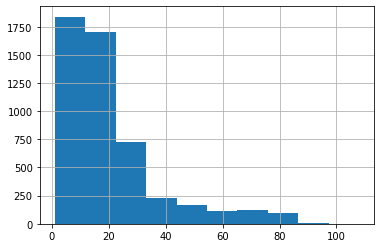

count    5000.000000
mean       20.227600
std        17.203633
min         1.000000
25%         9.000000
50%        15.000000
75%        25.000000
max       108.000000
dtype: float64

In [7]:
sent_len = [len(s[0].split()) for s in dataset.data]
pd.Series(sent_len).hist()
plt.show()
pd.Series(sent_len).describe()

In [8]:
from collections import defaultdict

dic = defaultdict(int)

for n in sent_len:
    dic[n] += 1
    
dic

defaultdict(int,
            {1: 68,
             2: 68,
             3: 100,
             4: 111,
             5: 141,
             6: 165,
             7: 257,
             8: 232,
             9: 224,
             10: 236,
             11: 237,
             12: 209,
             13: 195,
             14: 172,
             15: 164,
             16: 171,
             17: 146,
             18: 147,
             19: 144,
             20: 126,
             21: 127,
             22: 99,
             23: 110,
             24: 94,
             25: 90,
             26: 87,
             27: 76,
             28: 71,
             29: 45,
             30: 43,
             31: 43,
             32: 30,
             33: 39,
             34: 25,
             35: 28,
             36: 24,
             37: 28,
             38: 21,
             39: 25,
             40: 20,
             41: 24,
             42: 17,
             43: 18,
             44: 17,
             45: 19,
             46: 14,
      

In [9]:
total_cnt = 0
for length, cnt in dic.items():
    total_cnt += cnt
    if length == 64:
        print(total_cnt / len(sent_len) * 100)
        
    if (total_cnt // len(sent_len) * 100) > 90:
        print(length, cnt)

97.74000000000001
90 1


In [10]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
batch_size = 32

In [11]:
train_data, valid_data = random_split(dataset, [train_size, valid_size])

In [12]:
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size, shuffle=True)

In [13]:
train_sent, train_label = next(iter(train_dataloader))
print(train_sent)
print(train_label)
print(train_sent.size())

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-1.1913,  2.3943, -1.2083,  ..., -0.6147,  0.0499, -0.7020],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.5195, -0.5355,  3.3563,  ..., -2.5851,  2.0111, -0.8222],
         [-1.8232,  1.0065,  2.4744,  ...,  0.1948, -2.9623,  0.6539],
         [-0.2604, -0.0724, -0.3242,  ..., -0.6133,  0.8895, -0.1873]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [14]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=num_layers,batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size, self.output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, _ = self.lstm(x)
        
        drop_out = self.dropout(lstm_out)
        re_drop_out = drop_out.reshape([-1, self.hidden_size])
            
        linear_out = self.linear(re_drop_out)
        
        sig_out = self.sig(linear_out).reshape([batch_size, -1])[:, -1]
        
        return sig_out
        
    def init_hidden(self, batch_size, device):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        
        return (h0, c0)

In [15]:
num_layers = 2
input_size = 100
hidden_size = 128
output_dim = 1

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [16]:
lstm_model = SentimentLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim)

In [17]:
lstm_model.to(device)

SentimentLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sig): Sigmoid()
)

In [18]:
lr = 0.001
clip = 5
epochs = 5

loss_func = nn.BCELoss()#.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr)

def acc(pred, label):
    correct = torch.eq(pred.round(), label).sum().item()
    return correct

In [19]:
epoch_tr_acc, epoch_tr_loss = [], []
epoch_vl_acc, epoch_vl_loss = [],[]
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    lstm_model.train()
    #h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        #h = tuple([each.data for each in h])
        
        pred = lstm_model(inputs)
        
        loss = loss_func(pred, labels)
        loss.backward()
        train_losses.append(loss.item())
        
        accuracy = acc(pred, labels)

        train_acc += accuracy
        
        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tr_acc.append(epoch_train_acc)
    
    val_losses = []
    val_acc = 0.0
    lstm_model.eval()
    #val_h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(valid_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #val_h = tuple([each.data for each in val_h])
        pred = lstm_model(inputs)

        val_loss = loss_func(pred, labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(pred, labels)

        val_acc += accuracy
    
    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

100%|██████████| 32/32 [00:03<00:00,  9.14it/s]


Epoch 1
train_loss : 0.6693268094062805 val_loss : 0.6067649014294147
train_accuracy : 58.175 val_accuracy : 67.60000000000001


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 2
train_loss : 0.5805999884605407 val_loss : 0.5257674967870116
train_accuracy : 69.75 val_accuracy : 72.89999999999999


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 3
train_loss : 0.5126139755249024 val_loss : 0.5345989316701889
train_accuracy : 74.175 val_accuracy : 72.1


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 4
train_loss : 0.4442320042848587 val_loss : 0.5275940569117665
train_accuracy : 79.4 val_accuracy : 74.4


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]

Epoch 5
train_loss : 0.367914630651474 val_loss : 0.5548925092443824
train_accuracy : 83.325 val_accuracy : 71.2


In [21]:
torch.save(lstm_model, f='./')

IsADirectoryError: [Errno 21] Is a directory: '.'

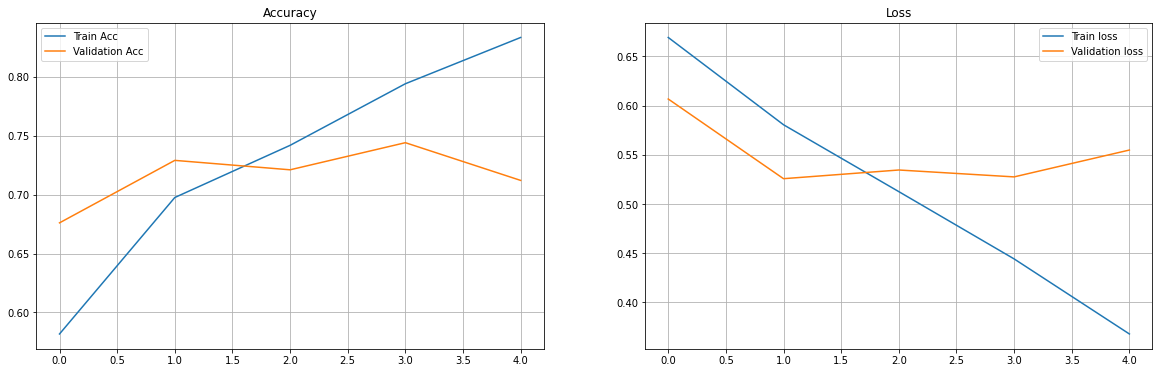

In [22]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()